In [91]:
import os
import matplotlib.pyplot as plt
from astropy.io import fits
import numpy as np
import pandas as pd
import matplotlib.cm as cm
import sys


#Astropy modules to deal with coordinates
from astropy.wcs import WCS
from astropy.wcs import Wcsprm
from astropy.io import fits
from astropy.wcs import utils

#BTS code developed by Seamus to get nice moment maps using cube masking
#instead of sigma clippping

module_path = os.path.abspath(os.path.join('/Users/christianflores/Documents/Work/BTS-master/')) # or the path to your source code
sys.path.insert(0, module_path)
import BTS


# The ALMA TP Data 
Thi class handles the basic properties of the fits files produced by ALMA.
"Description needed"

In [117]:
class ALMATPData:
    def __init__(self, path, filename):
        self.image = 1

        try:
            data_cube = fits.open(os.path.join(path, filename))
        except:
             data_cube = fits.open(os.path.join(path, filename + '.fits'))

        self.header = data_cube[0].header
        self.ppv_data = data_cube[0].data
        
        self.vel = self.get_vel(header)
        dv = self.vel[1] - self.vel[0]
        nv = len(self.vel)

        if(dv<0):
            self.vel = np.flip(self.vel,axis=0)
            ppv_data = np.flip(self.ppv_data,axis=0)
            dv = np.fabs(dv)
        
        self.wcs = WCS(self.header)
        

    def get_vel(self,head):
        ### If the header data is stored as frequency then convert to velocity [in km/s]
        if(head["CTYPE3"][0] == "F"):

            df = head['CDELT3']
            nf = head["CRPIX3"] 
            fr = head["CRVAL3"]

            ff = np.zeros(head["NAXIS3"])
            for ii in range(0,len(ff)):
                ff[ii] = fr + (ii-nf+1)*df

            rest = head["RESTFRQ"]

            vel = (rest-ff) / rest * 299792.458 
            return vel

        elif(head["CTYPE3"][0] == "V"):

            refnv = head["CRPIX3"]
            refv = head["CRVAL3"]
            dv = head["CDELT3"]
            ### Construct the velocity axis 

            vel = np.zeros(head["NAXIS3"])
            for ii in range(0,len(vel)):
                vel[ii] = refv + (ii-refnv+1)*dv

            return vel

        else:

            print("The CTYPE3 variable in the fitsfile header does not start with F for frequency or V for velocity")
            return

In [168]:
def plot_moment_maps(path,filename,moment):
    
    data_cube = ALMATPData(path,filename)
    image = data_cube.ppv_data
    
    fig = plt.subplot(projection=data_cube.wcs)
    figure = fig.imshow(image,cmap="viridis", origin='lower')
    
    if moment == 0: 
        cbar = plt.colorbar(figure, label='Integrated Intensity (Jy/beam * km/s)')
        plt.clabel(contour, inline=True, fontsize=8)
    elif moment == 1: 
        cbar = plt.colorbar(figure, label='Velocity (km/s)')
        plt.clabel(contour, inline=True, fontsize=8)
    elif moment == 2: 
        cbar = plt.colorbar(figure, label='Velocity width (km/s)')
        plt.clabel(contour, inline=True, fontsize=8)
        
    fig.tick_params(labelsize=12)
    plt.show()            


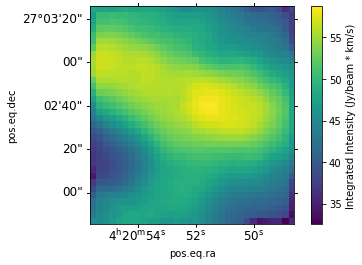

In [169]:
plot_moment_maps(path='.', filename='C18O_cube_M490_mom0.fits',moment=0)

In [14]:
def get_files_in_directory(directory_path):
    '''
    This function returns a list of the
    files and directories in directory_path
    '''
    try:
        #get a list of files and directory 
        file_list = os.listdir(directory_path)

        # Get only file names in directory 
        file_list = [file for file in file_list if os.path.isfile(os.path.join(directory_path, file))]

        return file_list
    except OSError as e:
        print(f"Error: {e}")
        return []

In [17]:
def make_average_spectrum_data(image_data,naxis1_value,naxis2_value,naxis3_value):
    """
    Average spectrum of the whole cube.
    """
    average_spectrum = np.zeros(naxis3_value)
    count=0
#     max_value=np.nanmax(image_data)
#     min_value=np.nanmin(image_data)

    for i in range(naxis1_value):
        for j in range(naxis2_value):
            for k in range(naxis3_value):
                average_spectrum[k] +=image_data[k,j,i]
            count=count+1

    average_spectrum=average_spectrum/count
    return average_spectrum

In [5]:
def make_average_spectrum(average_spectrum,velocity_axis_kms,mole_name,dir_each):    
    """
    This one actually only plots the average spectrum -> Change name
    """
    Vsys=7.0
    plt.figure()
    plt.title("Averaged Spectrum ("+mole_name+") @"+dir_each)
    plt.xlabel("velocity [km/s]")
    plt.ylabel("Intensity")
    # Set the value for horizontal line 
    y_horizontal_line = 0
    plt.axhline(y_horizontal_line, color='red', linestyle='-')
    plt.axvline(Vsys, color='red', linestyle='--')
    plt.plot(velocity_axis_kms,average_spectrum,"-",color="black",lw=1)
    plt.tick_params(axis='both', direction='in')
    plt.show()
    return

In [6]:
def frest_mole(spw):
    if spw=="spw17":
        file_end=".spw17.cube.I.sd.fits"
        freq_rest =2.165000000000E+11
        freq_rest =2.16278749E+11#c-C3H2
        freq_rest =2.16112628E+11#
        mole_name="DCO+"

    if spw=="spw19":
        file_end=".spw19.cube.I.sd.fits"
        freq_rest =2.199494420000E+11
        freq_rest =2.19949433E+11
        mole_name="SO"

    if spw=="spw21":
        file_end=".spw21.cube.I.sd.fits"
        freq_rest =2.195603580000E+11
        freq_rest = 2.19560353E+11
        mole_name="C18O"

    if spw=="spw23":
        file_end=".spw23.cube.I.sd.fits"
        freq_rest =2.300380000000E+11
        freq_rest = 2.30538000E+11
        mole_name="12CO"

    if spw=="spw25":
        file_end=".spw25.cube.I.sd.fits"
        freq_rest =2.312206860000E+11
        freq_rest = 2.31220768E+11
        mole_name="13CS"

    if spw=="spw27":
        file_end=".spw27.cube.I.sd.fits"
        freq_rest =2.313218283000E+11
        freq_rest = 2.31321635E+11
        mole_name="N2D+"
    return file_end,freq_rest,mole_name

In [63]:
 def define_mom_velo(dir_each,spw,mom_min_velo,mom_max_velo):
    if dir_each=="M490":
        if spw=="spw21":
            mom_min_velo=7.01-0.4
            mom_max_velo=7.01+0.4
    if dir_each=="M236":
        if spw=="spw21":
            mom_min_velo=6.69-0.4
            mom_max_velo=6.69+0.4            
    return mom_min_velo,mom_max_velo



In [84]:
def read_fits_files(path,file):
    hdul = fits.open(os.path.join(path,file))

    # Get  header information
    header = hdul[0].header
    naxis1_value = header['NAXIS1']
    naxis2_value = header['NAXIS2']
    try:
        naxis3_value = header['NAXIS3']
    except:
        print('No velocity information')

    # Get image
    image_data = hdul[0].data
    
#     image_data = image_data[0]
    # Close FITS file
    hdul.close()
    
    return naxis1_value, naxis2_value, image_data

No velocity information
(34, 32)


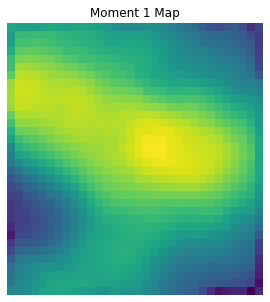

In [159]:
print(os.getcwd())

param = BTS.read_parameters("TP_FITS/M490/Fit_single_line.param")


# Fit the noisy spectrum and report the co-efficients and their errors
co_eff, errors, AIC = BTS.fit_single_line(velocity,spectrum,mask,param)
# print("The fitted amplitude = %.3lf p/m %.3lf, and the actual ampltiude = %.3lf" %(co_eff[0],errors[0],amplitude))
# print("The fitted centroid  = %.3lf p/m %.3lf, and the actual centroid  = %.3lf" %(co_eff[1],errors[1],centroid))
# print("The fitted width     = %.3lf p/m %.3lf, and the actual width     = %.3lf" %(co_eff[2],errors[2],sigma))


# #### Example to show how to make moment maps from a fits cube and then fit the entire cube

# # Read in the relevant parameter file



param = BTS.read_parameters("TP_FITS/M490/Fit_cube.param")

# print(os.getcwd())

# # Run the function to make the moments using the moment-masking technique
BTS.make_moments(param)

# # Using the generated mask, fit the entire datacube
# BTS.fit_a_fits(param)


#### Example to show how to run the single Gaussian test, checking the typical errors on the fitting parameters

# Read in the relevant parameter file
# param = BTS.read_parameters("TP_FITS/M490/Single_gaussian_test.param")

# Run the test which reports the errors on the amplitude, centroid and width
# BTS.single_gaussian_test(param)


# #### Example to show how to run the multiple Gaussian test, checking how accurate the number of velocity components is

# # Read in the relevant parameter file
# param = BTS.read_parameters("./Multi_gaussian_test.param")

# # Run the test which reports the number of spectrum fit with the incorrect number of components
# BTS.multi_gaussian_test(param)


/Users/christianflores/Work/GitHub/Core-rotation-project
 
 
 
############################################
################ Parameters ################
############################################

############# Important three ##############
Delta AIC limit                 =  10.0
Smoothing length                =  3.0
Signal to noise ratio           =  10.0
 
############# Input/Output names ###########
Input Fits file name            =  .member.uid___A001_X15aa_X2a6.M490_sci.spw21.cube.I.sd.fits
Output file base name           =  output
 
######## Spectral fitting parameters #######
Maximum number of peaks allowed =  4
Maximum number of iterations    =  5
Minimum number of channels      =  1
Minimum component width         =  0.02
Maximum component width         =  1.0
Mask padding value              =  3
 
######## Non-test noise parameters #########
Variable noise                  =  0
Constant noise level            =  0.1
 
######### Moment-masking parameters ########
Noise vel

||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
||||||||||||||||||||||||||||||||||||||||     M490   ||||||||||||||||||||||||||||||||||||||||||||||
||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
C18O@M490


<Figure size 3024x2520 with 0 Axes>

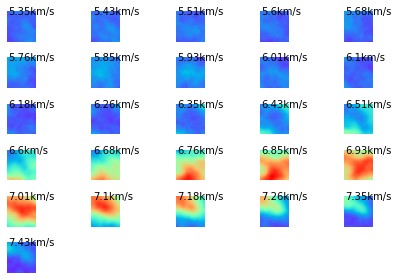

min,TTT 6.609999999999999 km/s
max,TTT 7.41 km/s


/var/folders/jn/82fcnwf57471_6bdfzxms7vm0000gn/T/ipykernel_91796/2704164870.py:199: UserWarning: The following kwargs were not used by contour: 'lw'
  contour=plt.contour(moment_0_map, levels=levels,colors="black",lw=0.5)


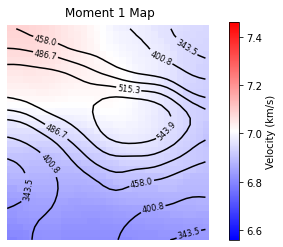

/var/folders/jn/82fcnwf57471_6bdfzxms7vm0000gn/T/ipykernel_91796/2704164870.py:214: UserWarning: The following kwargs were not used by contour: 'lw'
  contour=plt.contour(moment_0_map, levels=levels,colors="black",lw=0.5)


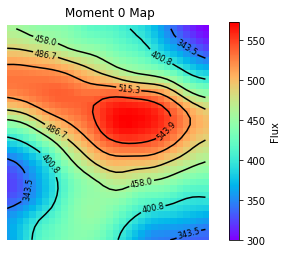

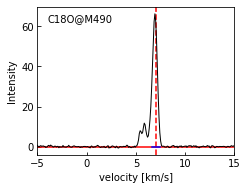

In [41]:
# select targets  
dir="./TP_FITS/" ### Change name of this variable because it is a built-in function name

# dir_eachs=["M236", "M350", "M449", "M493",
#            "M262", "M365", "M456", "M503",
#            "M273", "M387", "M457", "M505",
#            "M275", "M389", "M463", "M508",
#            "M295_296_280_281", "M424", "M465", "M510_M513_M514",
#            "M308", "M426", "M490"]
dir_eachs=["M490"]
#dir_eachs=["M510_M513_M514"]

target=[]
mole=[]
detect_status=[]

for j in range(len(dir_eachs)):
    dir_each=dir_eachs[j]
    print("||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||")
    print("||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||")
    print("||||||||||||||||||||||||||||||||||||||||     "+dir_each+"   ||||||||||||||||||||||||||||||||||||||||||||||")
    print("||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||")
    print("||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||")

    directory_path = dir+dir_each  # Change the path following your environment  
    files_in_directory = get_files_in_directory(directory_path)
    file_name_common=files_in_directory[0][:-21]

    spws=["spw21"]#,"spw19","spw21","spw23","spw25","spw27"]

    Vsys=7.0
    range_value=5.0
    thresh=7.5#sigma

    mom_range_begin=[]
    mom_range_end=[]
    
    for i in range(len(spws)):
        spw=spws[i]
        file_end,freq_rest,mole_name=frest_mole(spw)
        fits_file_path=dir+dir_each+"/"+file_name_common+file_end
        image_data,velocity_axis_kms,naxis1_value,naxis2_value,naxis3_value,bmag_value,header= read_fits(fits_file_path, freq_rest) 

        rms_start_ch=int(naxis3_value*2./10)
        rms_end_ch=int(naxis3_value*4./10)
        selected_channels = image_data[rms_start_ch:rms_end_ch]
        rms=np.nanstd(selected_channels)
        
        velo_range_count=0
        SN_value=0.
        
        ### I think tis part just gets the maximum SNR in the region where the line is suppose to be.
        for k in range(len(velocity_axis_kms)):
            max_value_map=np.nanmax(image_data[k])
            if (velocity_axis_kms[k] >= Vsys- range_value ) and (velocity_axis_kms[k] <= Vsys+ range_value ):
                SN_value_tmp=max_value_map/rms
                if SN_value_tmp >= SN_value:
                    SN_value=round(SN_value_tmp,1)
                if (max_value_map >= rms*thresh):
                    velo_range_count=velo_range_count+1
                
        if velo_range_count == 0:
            target.append(dir_each)
            mole.append(mole_name)
            #detect_status.append("X")
            input="X ("+str(SN_value)+")"
            detect_status.append(input)
            
        if velo_range_count != 0:
            target.append(dir_each)
            mole.append(mole_name)
            #detect_status.append("O")
            input="O ("+str(SN_value)+")"
            detect_status.append(input)
            
        default_size=7
        default_size2=7
        
        ### Here is just setting the layout for a figure, like chanel maps
        if velo_range_count == 1:
            plot_x,plot_y=1,1
            figsize_x,figsize_y=plot_x*default_size,plot_y*default_size
        if velo_range_count == 2:
            plot_x,plot_y=1,2            
            figsize_x,figsize_y=plot_x*default_size,plot_y*default_size
        if velo_range_count == 3:
            plot_x,plot_y=1,3            
            figsize_x,figsize_y=plot_x*default_size,plot_y*default_size
        if velo_range_count == 4:
            plot_x,plot_y=1,4            
            figsize_x,figsize_y=plot_x*default_size,plot_y*default_size
        if velo_range_count == 5:
            plot_x,plot_y=1,5            
            figsize_x,figsize_y=plot_x*default_size,plot_y*default_size
            
        if (velo_range_count >= 6) and (velo_range_count <= 10):
            plot_x,plot_y=2,5           
            figsize_x,figsize_y=plot_x*default_size,plot_y*default_size2    
        if (velo_range_count >= 11) and (velo_range_count <= 15):
            plot_x,plot_y=3,5           
            figsize_x,figsize_y=plot_x*default_size,plot_y*default_size2
        if (velo_range_count >= 16) and (velo_range_count <= 20):
            plot_x,plot_y=4,5           
            figsize_x,figsize_y=plot_x*default_size,plot_y*default_size2
        if (velo_range_count >= 21) and (velo_range_count <= 25):
            plot_x,plot_y=5,5           
            figsize_x,figsize_y=plot_x*default_size,plot_y*default_size2
        if (velo_range_count >= 26) and (velo_range_count <= 30):
            plot_x,plot_y=6,5           
            figsize_x,figsize_y=plot_x*default_size,plot_y*default_size2       
        if (velo_range_count >= 31) and (velo_range_count <= 36):
            plot_x,plot_y=6,6           
            figsize_x,figsize_y=plot_x*default_size,plot_y*default_size2
        if (velo_range_count >= 37) :
            plot_x,plot_y=7,7
            figsize_x,figsize_y=plot_x*default_size,plot_y*default_size2
            
        if velo_range_count == 0:            
            mom_range_begin.append(-100)
            mom_range_end.append(100)
            
        ### Here is plotting the figures. This looks like a channel map.
        if velo_range_count >= 1:
            velo_range_count=0
            plt.figure(figsize=(figsize_x,figsize_y))
            plt.figure()
            plt.title(mole_name+"@"+dir_each)
            text=mole_name+"@"+dir_each
            print(text)
            mom_min_velo=100.
            mom_max_velo=-100.
            for k in range(len(velocity_axis_kms)):
                max_value_map=np.nanmax(image_data[k])
                if (velocity_axis_kms[k] >= Vsys- range_value ) and (velocity_axis_kms[k] <= Vsys+ range_value ):
                    if (max_value_map >= rms*thresh):
                        if velocity_axis_kms[k] <= mom_min_velo:
                            mom_min_velo=velocity_axis_kms[k]
                        if velocity_axis_kms[k] >= mom_max_velo:
                            mom_max_velo=velocity_axis_kms[k]                        
                        
                        velo_range_count=velo_range_count+1
                        num=velo_range_count
                        plt.subplot(plot_x,plot_y,num)
                        plt.xlim(0,naxis1_value)
                        plt.ylim(0,naxis2_value)
                        plt.imshow(image_data[k],cmap="rainbow",vmin=np.nanmin(image_data),vmax=np.nanmax(image_data))
                        relative_x=0.05
                        relative_y=0.9
                        velo_text=round(velocity_axis_kms[k],2)
                        plt.text(relative_x, relative_y, str(velo_text)+"km/s", transform=plt.gca().transAxes)
                        plt.axis('off')

            plt.tight_layout()  
            plt.show()
            
            ## The velocity of the moment maps are defined by hand in a function
            mom_min_velo_tmp,mom_max_velo_tmp=define_mom_velo(dir_each,spw,mom_min_velo,mom_max_velo)
            
            print("min,TTT",mom_min_velo_tmp, "km/s")
            print("max,TTT",mom_max_velo_tmp, "km/s")            
            mom_range_begin.append(mom_min_velo_tmp)
            mom_range_end.append(mom_max_velo_tmp)
            mom_min_velo=mom_min_velo_tmp
            mom_max_velo=mom_max_velo_tmp
            
            
            ## Here the moment maps are plotted

            if num >=3:
                # Set the velocity range 
                min_velocity = mom_min_velo-0.05  # Min velocity（km/s）
                max_velocity = mom_max_velo+0.05   # Max velocity （km/s）

                velocity_mask = (velocity_axis_kms >= min_velocity) & (velocity_axis_kms <= max_velocity)
                data_cube_cut = image_data[velocity_mask, :, :]
                
                moment_0_map = np.sum(data_cube_cut, axis=0)            
                
                #Set intensity threshold 
                intensity_threshold = rms*5.0#5sigma

                # Making mask to neglect the pixels below the intensity threshold  
                intensity_mask = data_cube_cut < intensity_threshold
                data_cube_cut[intensity_mask] = 0.0  # set 0 to the pixels below intensity threshold 

                # Make mom 1 maps 
                weighted_velocity = np.sum(data_cube_cut * velocity_axis_kms[velocity_mask, None, None], axis=0) / np.sum(data_cube_cut, axis=0)

                peak=np.nanmax(moment_0_map)
                levels = np.array([0.3, 0.4, 0.5, 0.6,0.7,0.8,0.85, 0.9,0.95])
                levels=levels* peak
                
                #Plot Mom 1 map
                plt.figure()
                plt.xlim(0,naxis1_value)
                plt.ylim(0,naxis2_value)
                plt.imshow(weighted_velocity, cmap='bwr',  vmin=min_velocity, vmax=max_velocity)
                plt.colorbar(label='Velocity (km/s)')
                contour=plt.contour(moment_0_map, levels=levels,colors="black",lw=0.5)
                plt.clabel(contour, inline=True, fontsize=8)

                plt.xlabel('X-axis (pixel)')
                plt.ylabel('Y-axis (pixel)')
                plt.title('Moment 1 Map')
                plt.axis('off')
                plt.show()            
                
                #Plot Mom 0 map
                plt.figure()
                plt.xlim(0,naxis1_value)
                plt.ylim(0,naxis2_value)
                plt.imshow(moment_0_map, cmap='rainbow')
                plt.colorbar(label='Flux')
                contour=plt.contour(moment_0_map, levels=levels,colors="black",lw=0.5)
                plt.clabel(contour, inline=True, fontsize=8)
                plt.xlabel('X-axis (pixel)')
                plt.ylabel('Y-axis (pixel)')
                plt.title('Moment 0 Map')
                plt.axis('off')
                plt.show()            
            print("==================================================")
            print("==================================================")
            print("==================================================")

    plt.figure(figsize=(12,6))
    
    ## Here the spectrum of the source is plotted
    for i in range(len(spws)):
        spw=spws[i]
        file_end,freq_rest,mole_name=frest_mole(spw)
        fits_file_path=dir+dir_each+"/"+file_name_common+file_end
        image_data,velocity_axis_kms,naxis1_value,naxis2_value,naxis3_value,bmag_value,header= read_fits(fits_file_path, freq_rest)
        average_spectrum=make_average_spectrum_data(image_data,naxis1_value,naxis2_value,naxis3_value)
        #make_average_spectrum(average_spectrum,velocity_axis_kms,mole_name,dir_each)
        
        num=int(i+1)
        plt.subplot(2,3,num)
        #plt.title("Averaged Spectrum ("+mole_name+") @"+dir_each)
        relative_x=0.05
        relative_y=0.9
        plt.text(relative_x, relative_y, mole_name+"@"+dir_each, transform=plt.gca().transAxes)

        plt.xlabel("velocity [km/s]")
        plt.ylabel("Intensity")
        plt.xlim(-5,15)
        # set the value for horizontal line
        y_horizontal_line = 0
        plt.axhline(y_horizontal_line, color='red', linestyle='-')

        plt.axvline(Vsys, color='red', linestyle='--')
        plt.plot(velocity_axis_kms,average_spectrum,"-",color="black",lw=1)
        plt.tick_params(axis='both', direction='in')
        if (mom_range_begin[i] != -100) :
            plt.plot([mom_range_begin[i],mom_range_end[i]],[0,0],"-",color="blue")
        
    plt.show()        
    
    
data = {
    'Target': target,
    'Molecule': mole,
    'Detect': detect_status
}

df = pd.DataFrame(data)

In [36]:
pivot_table = pd.pivot(data=df, index='Target', columns='Molecule', values='Detect')
print("Results based on threshold:",thresh, "sigma")
pivot_table

Results based on threshold: 7.5 sigma


Molecule      C18O
Target            
M490      O (73.9)

In [30]:
pivot_table = pd.pivot(data=df, index='Molecule', columns='Target', values='Detect')
print("Results based on threshold:",thresh, "sigma")
pivot_table

Results based on threshold: 7.5 sigma


Target        M490
Molecule          
DCO+      O (13.8)

In [31]:
dir_each="M493"
spw="spw21"

directory_path = dir+dir_each  # 自分のディレクトリのパスに置き換えてください
files_in_directory = get_files_in_directory(directory_path)
file_name_common=files_in_directory[0][:-21]

file_end,freq_rest,mole_name=frest_mole(spw)
fits_file_path=dir+dir_each+"/"+file_name_common+file_end

In [32]:
print(fits_file_path)

./TP_FITS/M493/member.uid___A001_X15aa_X29e.M493_sci.spw21.cube.I.sd.fits


In [33]:
image_data,velocity_axis_kms,naxis1_value,naxis2_value,naxis3_value,bmag_value,header= read_fits(fits_file_path, freq_rest) 

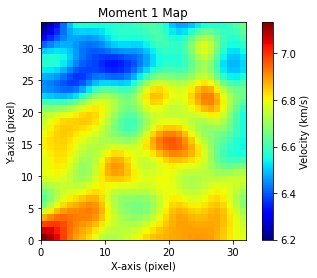

In [34]:
# 速度範囲の指定
min_velocity = 2  # 最小速度（km/s）
max_velocity = 12   # 最大速度（km/s）

velocity_mask = (velocity_axis_kms >= min_velocity) & (velocity_axis_kms <= max_velocity)
data_cube_cut = image_data[velocity_mask, :, :]
# モーメント1マップを計算する（重み付け平均速度を計算）
weighted_velocity = np.sum(data_cube_cut * velocity_axis_kms[velocity_mask, None, None], axis=0) / np.sum(data_cube_cut, axis=0)

# モーメント1マップをプロットする
plt.imshow(weighted_velocity, origin='lower', cmap='jet', extent=[0, header['NAXIS1'], 0, header['NAXIS2']])
plt.colorbar(label='Velocity (km/s)')
plt.xlabel('X-axis (pixel)')
plt.ylabel('Y-axis (pixel)')
plt.title('Moment 1 Map')
plt.show()